## Robust Mean - Variance Portfolio Optimization

Robust portfolio optimization is a variant of traditional portfolio optimization. The objective is to allocate a total investment amount across different assets to maximize the portfolio's expected return, while ensuring a very low probability (e.g., 0.5%) that the actual return falls below this expected value. This approach addresses the uncertainty inherent in portfolio returns, making it a robust optimization problem.

In the example taken from Bertsimas and Den Hertog (2015) [1], Section 3.4, we have n = 200 assets. Let $r_i$ denote the return of the $i$-th asset. The return on Asset #200 $r_{n}=1.05$ has zero variability. The returns of the remaining assets $r_i$, $\forall i \in [n - 1]$, are random variables taking values in the intervals $[\mu_i - \sigma_i ,\mu_i + \sigma_i  ]$. $\vec{\mu}$ and $\vec{\sigma}$ are defined as:

$$ \mu_i = 1.05 + \frac{0.3\left(n - i\right)}{n - 1} , \space \sigma_i = 0.05 + \frac{0.6\left(n - i\right)}{n - 1}, \space \forall i \in [n - 1] $$



To solve this problem, we first import the required packages and generate the data. 

In [1]:
import lropt
import cvxpy as cp
import numpy as np
import warnings
import altair as alt
import pandas as pd
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)


In [2]:
N = 200
GUARANTEED_RETURN = 1.05
b2 = 0.3
b3 = 0.05
b4 = 0.6
P = 2
RHO_VALUES = [0.5, 1.0, 1.5, 2.0] 
mu = np.zeros(N - 1)
for i in range(N - 1):
    mu_i = GUARANTEED_RETURN + b2 * (N - i) / (N- 1)
    mu[i] = mu_i  

sigma = np.zeros(N - 1)
for i in range(N - 1):
    sigma_i = b3 + b4 * (N - i) / (N - 1)
    sigma[i] = sigma_i 


The problem we want to solve is the uncertain linear optimization problem:

$$ 
\begin{aligned}
& \text{maximize} \quad t\\
& \text{subject to} \quad \mu^T x + \sigma^T x + 1.05x \geq t , \\
& 1^T x= 1, \\
& x \geq 0
\end{aligned}
$$

$ x_i $ is the capital to be invested in asset $i$. The guarenteed yearly return is 1.05.



In this problem, the uncertain data are the retuns $r_i = \mu_i + \sigma_i z_i, i \in [199]$ where $z_i, i\in[199]$, are independant random variables with zero mean varying in the segments $[-1, 1]$. The robust counterpart to the uncertain linear optimization problem is:


$$ 
\begin{aligned}
& \text{maximize} \quad t\\
& \text{subject to} \quad (\mu + \sigma^T z)x + 1.05x \geq t , \quad \forall z \in \mathcal{Z}, \\
& 1^Tx= 1, \\
& x \geq 0
\end{aligned}
$$

for a variety of uncertainty sets $ \mathcal{Z} $. 

In the following snippet, we solve this problem using  Ellipsoidal, Box and Budget uncertainty sets and compare the results. The definitions for each cells are the following: 

Budget : $ \mathcal{U}_{\text{budget}} = \{Az+b \ | \ \|z \|_\infty \le \rho_1,
        \|z \|_1 \leq \rho_2\} $

Ellipsoidal : $\mathcal{U}_{\text{ellips}} = \{Az+b \ | \ \| z\|_2 \le \rho\}$


In [3]:
names = ['ellipsoidal', 'budget', 'box']
results = []
for rho in RHO_VALUES:
    uncertainty_sets = [lropt.Ellipsoidal(rho = rho, a = np.diag(sigma), b = mu), lropt.Budget(rho1 = rho, rho2 = rho, b= mu, a = np.diag(sigma)), lropt.Box(rho = rho, a = np.diag(sigma), b = mu)]
    
    for uc in enumerate(uncertainty_sets):

        t = cp.Variable()
        x = cp.Variable(N, nonneg=True)
        z = lropt.UncertainParameter(N - 1, uncertainty_set=uc[1])

        constraints = [
        (mu + sigma @ z) @ x[:(N-1)] + GUARANTEED_RETURN * x[-1] >=t,
        cp.sum(x) == 1
        ]

        objective = cp.Maximize(t)
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        results.append({
            'rho': rho,
            'uncertainty_set': names[uc[0]],
            'robust_value': float(t.value)
        })

In [4]:
df = pd.DataFrame(results)
chart = alt.Chart(df).mark_line(point=True, color='black').encode(
    x=alt.X('rho:O', title='Rho Value', axis=alt.Axis(grid=False, titleFontSize=14, labelFontSize=12)),
    y=alt.Y('robust_value:Q', title='Robust Value', axis=alt.Axis(grid=True, titleFontSize=14, labelFontSize=12)),
    color=alt.Color('uncertainty_set:N', title='Uncertainty Set', scale=alt.Scale(scheme='set1')),
    strokeDash=alt.StrokeDash('uncertainty_set:N', title='Uncertainty Set'),
    tooltip=[
        alt.Tooltip('rho:O', title='Rho'),
        alt.Tooltip('robust_value:Q', title='Robust Value'),
        alt.Tooltip('uncertainty_set:N', title='Uncertainty Set')
    ]
).properties(
    title='Trade-off Curves for Robust Portfolio Optimization',
    width=700,  
    height=500  
).interactive() 
chart.show()

alt.Chart(...)

In [8]:
results

[{'rho': 0.5,
  'uncertainty_set': 'ellipsoidal',
  'robust_value': 87.74459095563665},
 {'rho': 0.5, 'uncertainty_set': 'budget', 'robust_value': 88.94275298670252},
 {'rho': 0.5, 'uncertainty_set': 'box', 'robust_value': 73.66524251916074},
 {'rho': 1.0,
  'uncertainty_set': 'ellipsoidal',
  'robust_value': 86.33321457458987},
 {'rho': 1.0, 'uncertainty_set': 'budget', 'robust_value': 88.72953863795945},
 {'rho': 1.0, 'uncertainty_set': 'box', 'robust_value': 58.17454754946674},
 {'rho': 1.5,
  'uncertainty_set': 'ellipsoidal',
  'robust_value': 84.92183819354311},
 {'rho': 1.5, 'uncertainty_set': 'budget', 'robust_value': 88.51632428853102},
 {'rho': 1.5, 'uncertainty_set': 'box', 'robust_value': 42.68383768858729},
 {'rho': 2.0,
  'uncertainty_set': 'ellipsoidal',
  'robust_value': 83.5104618124963},
 {'rho': 2.0, 'uncertainty_set': 'budget', 'robust_value': 88.30310995864616},
 {'rho': 2.0, 'uncertainty_set': 'box', 'robust_value': 27.193128139738455}]

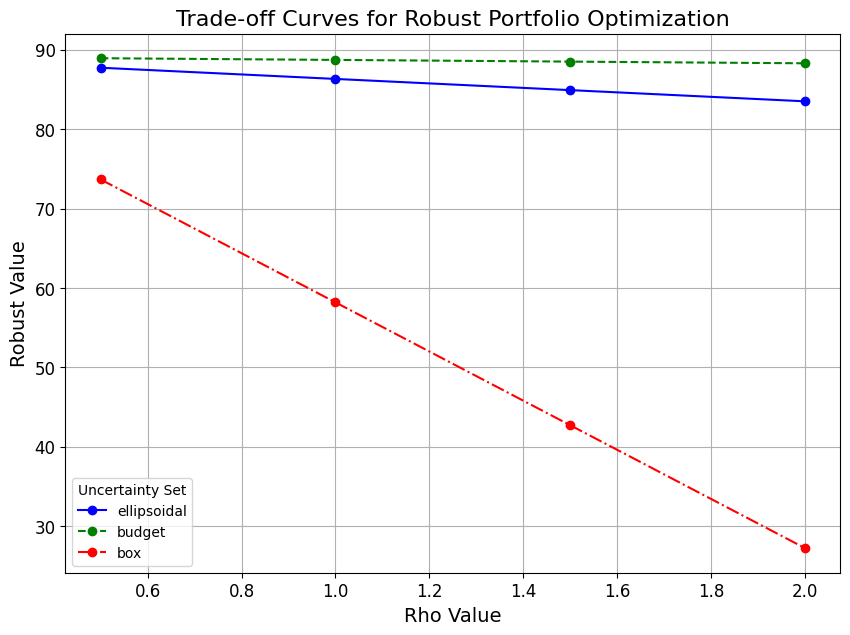

In [9]:
import matplotlib.pyplot as plt
df = pd.DataFrame(results)


colors = {'ellipsoidal': 'blue', 'budget': 'green', 'box': 'red'}
linestyles = {'ellipsoidal': '-', 'budget': '--', 'box': '-.'}


fig, ax = plt.subplots(figsize=(10, 7))


for label in df['uncertainty_set'].unique():
    subset = df[df['uncertainty_set'] == label]
    ax.plot(subset['rho'], subset['robust_value'],
            marker='o',
            color=colors[label],
            linestyle=linestyles[label],
            label=label)

# Set labels and title
ax.set_xlabel('Rho Value', fontsize=14)
ax.set_ylabel('Robust Value', fontsize=14)
ax.set_title('Trade-off Curves for Robust Portfolio Optimization', fontsize=16)


ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)


ax.legend(title='Uncertainty Set')

# Show plot
plt.show()


# References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.